# Load Dataset

In [ ]:
import pandas as pd
content = pd.read_csv('content.csv')

In [ ]:
content.head()

,sentences,question,answer
0,i am not looking for a job change,is it about answer,1
1,i dont want to leave my hometown,is it about answer,1
2,we can have next round tomorrow,is it about answer,1
3,i have experience with end to end application ...,is it about answer,1
4,monday works for me,is it about answer,1


In [ ]:
content['answer'].value_counts()

0    3212
1     803
Name: answer, dtype: int64

In [ ]:
content = content.sample(frac=1).reset_index(0)

In [ ]:
content = content.drop(columns = ['index'])

In [ ]:
content

,sentences,question,answer
0,what clan was king idris part of,is it about reschedule,0
1,where does its name come from,is it about repeat,0
2,i will call you later,is it about question,0
3,what was austpac,is it about wait,0
4,secure blue was launched in what year,is it about question,1
...,...,...,...
4010,i m sorry but i won t be able to speak with yo...,is it about repeat,0
4011,what brought communism,is it about answer,0
4012,tell me what you just said once again please,is it about repeat,1
4013,on tuesday,is it about answer,1


In [ ]:
!pip install torch torchvision
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.4 MB/s 
     |████████████████████████████████| 61 kB 503 kB/s 
     |████████████████████████████████| 895 kB 32.9 MB/s 
     |████████████████████████████████| 596 kB 43.7 MB/s 
     |████████████████████████████████| 3.3 MB 30.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW


# Load Model

In [1]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seeds for reproducibility
random.seed(26)
np.random.seed(26)
torch.manual_seed(26)

tokenizer = AutoTokenizer.from_pretrained("roberta-base") 

model = AutoModelForSequenceClassification.from_pretrained("roberta-base")
model.to(device) # Send the model to the GPU if we have one

learning_rate = 4e-6
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

NameError: ignored

# Encode Data

In [2]:
def encode_data(tokenizer, questions, passages, max_length):
    """Encode the question/passage pairs into features than can be fed to the model."""
    input_ids = []
    attention_masks = []

    for question, passage in zip(questions, passages):
        encoded_data = tokenizer.encode_plus(question, passage, max_length=max_length, pad_to_max_length=True, truncation_strategy="longest_first")
        encoded_pair = encoded_data["input_ids"]
        attention_mask = encoded_data["attention_mask"]

        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)

    return np.array(input_ids), np.array(attention_masks)


In [3]:
print('shape before :',content.shape)
all_ones = content[content['answer']==1]
content = pd.concat([content, all_ones, all_ones, all_ones, all_ones, all_ones, all_ones, all_ones, all_ones, all_ones, all_ones, all_ones], axis=0)
print('shape after :',content.shape)

NameError: ignored

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(content, test_size = 0.1, stratify=content['answer'])

In [ ]:
train['answer'].value_counts()

In [ ]:
test['answer'].value_counts()

In [ ]:
train = train.reset_index()
test = test.reset_index()

In [ ]:
questions_train = train.question.values
answers_train = train.answer.values.astype(int)
passages_train = train.sentences.values


questions_dev = test.question.values
answers_dev = test.answer.values.astype(int)
passages_dev = test.sentences.values

In [ ]:
max_seq_length = 32
input_ids_train, attention_masks_train = encode_data(tokenizer, questions_train, passages_train, max_seq_length)
input_ids_dev, attention_masks_dev = encode_data(tokenizer, questions_dev, passages_dev, max_seq_length)


In [ ]:
attention_masks_dev[0], attention_masks_dev[1], attention_masks_dev[2], attention_masks_dev[3]

In [ ]:
train_features = (input_ids_train, attention_masks_train, answers_train)
dev_features = (input_ids_dev, attention_masks_dev, answers_dev)

In [ ]:
batch_size = 16

train_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in train_features]
dev_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in dev_features]
print(train_features_tensors)
train_dataset = TensorDataset(*train_features_tensors)
dev_dataset = TensorDataset(*dev_features_tensors)
print(train_dataset)
train_sampler = RandomSampler(train_dataset)
dev_sampler = SequentialSampler(dev_dataset)
print(train_sampler)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=batch_size)
print(train_dataloader)

In [ ]:
train_sampler

# Train Model

In [ ]:
epochs = 20
grad_acc_steps = 1
train_loss_values = []
dev_acc_values = []

for _ in tqdm(range(epochs), desc="Epoch"):

  # Training
  epoch_train_loss = 0 # Cumulative loss
  model.train()
  model.zero_grad()

  for step, batch in enumerate(train_dataloader):

      input_ids = batch[0].to(device)
      attention_masks = batch[1].to(device)
      labels = batch[2].to(device)     

      outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels)
      
      loss = outputs[0]
      loss = loss / grad_acc_steps
      epoch_train_loss += loss.item()

      loss.backward()
      
      if (step+1) % grad_acc_steps == 0: # Gradient accumulation is over
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clipping gradients
        optimizer.step()
        model.zero_grad()

  epoch_train_loss = epoch_train_loss / len(train_dataloader)          
  train_loss_values.append(epoch_train_loss)
  
  # Evaluation
  epoch_dev_accuracy = 0 # Cumulative accuracy
  model.eval()

  for batch in dev_dataloader:
    
    input_ids = batch[0].to(device)
    attention_masks = batch[1].to(device)
    labels = batch[2]
                
    with torch.no_grad():        
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    
    predictions = np.argmax(logits, axis=1).flatten()
    labels = labels.numpy().flatten()
    
    epoch_dev_accuracy += np.sum(predictions == labels) / len(labels)

  epoch_dev_accuracy = epoch_dev_accuracy / len(dev_dataloader)
  dev_acc_values.append(epoch_dev_accuracy)


Epoch: 100%|██████████| 20/20 [25:21<00:00, 76.10s/it]


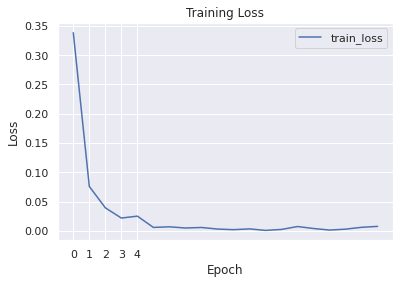

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

plt.plot(train_loss_values, label="train_loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.xticks(np.arange(0, 5))
plt.show()

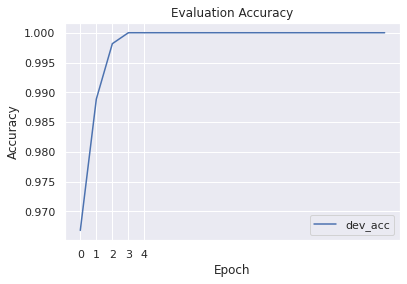

In [ ]:
plt.plot(dev_acc_values, label="dev_acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.legend()
plt.xticks(np.arange(0, 5))
plt.show()

# Model Inference

In [ ]:
def predict(questions, passage):
  for question in questions:
    sequence = tokenizer.encode_plus(question, passage, return_tensors="pt")['input_ids'].to(device)
    
    logits = model(sequence)[0]
    probabilities = torch.softmax(logits, dim=1).detach().cpu().tolist()[0]
    proba_yes = round(probabilities[1], 2)
    proba_no = round(probabilities[0], 2)

    print(f"Question: {question}, Yes: {proba_yes}, No: {proba_no}")
  print('*'*20)
# passage_superbowl = """Super Bowl 50 was an American football game to determine the champion of the National Football League
#                     (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated
#                     the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title.
#                     The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara,
#                     California. As this was the 50th Super Bowl, the league emphasized the 'golden anniversary' with various
#                     gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game
#                     with Roman numerals (under which the game would have been known as 'Super Bowl L'), so that the logo could
#                     prominently feature the Arabic numerals 50."""
 
# passage_illuin = """Illuin designs and builds solutions tailored to your strategic needs using Artificial Intelligence
#                   and the new means of human interaction this technology enables."""

# superbowl_questions = [
# "Did the Denver Broncos win the Super Bowl 50?", 
# "Did the Carolina Panthers win the Super Bowl 50?",
# "Was the Super Bowl played at Levi's Stadium?", 
# "Was the Super Bowl 50 played in Las Vegas?", 
# "Was the Super Bowl 50 played in February?", 
# "Was the Super Bowl 50 played in March?"
# ]

# question_illuin = "Is Illuin the answer to your strategic needs?"

# for s_question in superbowl_questions:
#   predict(s_question, passage_superbowl)

# predict(question_illuin, passage_illuin)
